This notebook demonstrates demand forecasting for Beer Production Dataset using AutoML.

## Prepare train data

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
from dateutil.relativedelta import relativedelta

In [2]:
time_column_name = 'DATE' # Specify the column that contains time series data

df_train = pd.read_csv("Beer_no_valid_split_train.csv", parse_dates=[time_column_name]).drop(columns='grain')
df_train.head(10)

,DATE,BeerProduction
0,1992-01-01,3459
1,1992-02-01,3458
2,1992-03-01,4002
3,1992-04-01,4564
4,1992-05-01,4221
5,1992-06-01,4529
6,1992-07-01,4466
7,1992-08-01,4137
8,1992-09-01,4126
9,1992-10-01,4259


In [3]:
df_train.describe()

,BeerProduction
count,300.000000
mean,7491.796667
std,2634.362440
min,3031.000000
25%,5095.250000
50%,7162.000000
75%,9477.250000
max,14431.000000


In [4]:
import matplotlib.pyplot as plt
df_train.plot(time_column_name, figsize=(20,10))

## Configure workspace


Create a workspace object from the existing workspace. A [Workspace](https://docs.microsoft.com/python/api/azureml-core/azureml.core.workspace.workspace?view=azure-ml-py) is a class that accepts your Azure subscription and resource information. It also creates a cloud resource to monitor and track your model runs. `Workspace.from_config()` reads the file **config.json** and loads the authentication details into an object named `ws`. `ws` is used throughout the rest of the code in this tutorial.

In [5]:
from azureml.core.workspace import Workspace
ws = Workspace.from_config()

## Automatically train a model

To automatically train a model, take the following steps:
1. Define settings for the experiment run. Attach your training data to the configuration, and modify settings that control the training process.
1. Submit the experiment for model tuning. After submitting the experiment, the process iterates through different machine learning algorithms and hyperparameter settings, adhering to your defined constraints. It chooses the best-fit model by optimizing an accuracy metric.

### Define training settings

Define the experiment parameter and model settings for training. View the full list of [settings](https://docs.microsoft.com/azure/machine-learning/service/how-to-configure-auto-train) and [AutoMLConfig](https://docs.microsoft.com/en-us/python/api/azureml-train-automl-client/azureml.train.automl.automlconfig.automlconfig?view=azure-ml-py).

|Property| Value in this tutorial |Description|
|:---|:---|:---|
|**time_column_name**|DATE|The name of the time column. This parameter is required when forecasting to specify the datetime column in the input data used for building the time series and inferring its frequency.|
|**max_horizon**|12|Forecaster maximum horizon. The forecast horizon is the number of periods into the future that the model should predict. Here, we set the horizon to 12 periods (i.e. 12 months). Notice that this is much shorter than the number of months in the test set; we will need to use a rolling test to evaluate the performance on the whole test set.|

|Property| Value in this tutorial |Description|
|:---|:---|:---|
|**task**|forecasting|The type of task to run. Values can be 'classification', 'regression', or 'forecasting' depending on the type of automated ML problem to solve.|
|**primary_metric**|normalized_root_mean_squared_error|This is the metric that you want to optimize. Forecasting supports the following primary metrics <br> _spearman_correlation_ <br> _normalized_root_mean_squared_error_ <br> _r2_score_ <br> _normalized_mean_absolute_error_|
|**experiment_timeout_minutes**|15|Experimentation timeout in minutes.|
|**training_data**|df_train|Input dataset, containing both features and label column.|
|**label_column_name**|BeerProduction|The name of the label column.|
|**n_cross_validations**|5|Number of cross-validation splits to perform when validation data is not specified.|
|**debug_log**|automl_experiment_errors.log|Log file path for writing debugging information.|
|**verbosity**| logging.INFO |Controls the level of logging.|

In [6]:
import logging
from azureml.train.automl import AutoMLConfig

time_series_settings = {
    'time_column_name': time_column_name,
    'max_horizon': 12
}

automl_config = AutoMLConfig(task = 'forecasting',                             
                             primary_metric='normalized_root_mean_squared_error',
                             experiment_timeout_minutes=15,
                             training_data=df_train,
                             label_column_name='BeerProduction',
                             n_cross_validations=5,
                             debug_log='automl_experiment_errors.log',
                             verbosity=logging.INFO,
                             **time_series_settings)

In [7]:
import warnings
warnings.filterwarnings('ignore')

### Train the automatic regression model

Create an experiment object in your workspace. An experiment acts as a container for your individual runs. Pass the defined `automl_config` object to the experiment, and set the output to `True` to view progress during the run. 

After starting the experiment, the output shown updates live as the experiment runs. For each iteration, you see the model type, the run duration, and the training accuracy. The field `BEST` tracks the best running training score based on your metric type.

In [8]:
from azureml.core.experiment import Experiment
experiment = Experiment(ws, "beer-experiment")
local_run = experiment.submit(automl_config, show_output=True)

Running on local machine
Parent Run ID: AutoML_2d2e6c7a-bbbf-4613-ab34-1b0ef4b75a54

Current status: DatasetFeaturization. Beginning to featurize the dataset.


WARNING - Converting non-string tag to string: (forecasting_target_lags: [0])
WARNING - Converting non-string tag to string: (forecasting_target_rolling_window_size: 0)
WARNING - Converting non-string tag to string: (forecasting_max_horizon: 12)


Current status: DatasetFeaturizationCompleted. Completed featurizing the dataset.
Current status: DatasetCrossValidationSplit. Generating individually featurized CV splits.
Current status: DatasetFeaturization. Beginning to featurize the CV split.
Current status: DatasetFeaturizationCompleted. Completed featurizing the CV split.
Current status: DatasetFeaturization. Beginning to featurize the CV split.
Current status: DatasetFeaturizationCompleted. Completed featurizing the CV split.
Current status: DatasetFeaturization. Beginning to featurize the CV split.
Current status: DatasetFeaturizationCompleted. Completed featurizing the CV split.
Current status: DatasetFeaturization. Beginning to featurize the CV split.
Current status: DatasetFeaturizationCompleted. Completed featurizing the CV split.
Current status: DatasetFeaturization. Beginning to featurize the CV split.
Current status: DatasetFeaturizationCompleted. Completed featurizing the CV split.

************************************

## Explore the results

Explore the results of automatic training with a [Jupyter widget](https://docs.microsoft.com/python/api/azureml-widgets/azureml.widgets?view=azure-ml-py). The widget allows you to see a graph and table of all individual run iterations, along with training accuracy metrics and metadata. Additionally, you can filter on different accuracy metrics than your primary metric with the dropdown selector.

In [9]:
from azureml.widgets import RunDetails
RunDetails(local_run).show()

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', 's…

### Retrieve the best model

In [10]:
best_run, fitted_model = local_run.get_output()
print(best_run)
print(fitted_model)

Run(Experiment: beer-experiment,
Id: AutoML_2d2e6c7a-bbbf-4613-ab34-1b0ef4b75a54_46,
Type: None,
Status: Completed)
ForecastingPipelineWrapper(pipeline=Pipeline(memory=None,
     steps=[('timeseriestransformer', TimeSeriesTransformer(featurization_config=None, logger=None,
           pipeline_type=<TimeSeriesPipelineType.FULL: 1>)), ('prefittedsoftvotingregressor', PreFittedSoftVotingRegressor(estimators=[('8', Pipeline(memory=None,
     steps=[('standardscalerwrapper', <azu...6666666666666, 0.06666666666666667, 0.06666666666666667, 0.06666666666666667, 0.4666666666666667]))]),
              stddev=None)


### Test the best model accuracy

In [11]:
df_test = pd.read_csv("Beer_no_valid_split_test.csv", parse_dates=[time_column_name]).drop(columns='grain')
df_test.head(10)

,DATE,BeerProduction
0,2017-01-01,9049
1,2017-02-01,10458
2,2017-03-01,12489
3,2017-04-01,11499
4,2017-05-01,13553
5,2017-06-01,14740
6,2017-07-01,11424
7,2017-08-01,13412
8,2017-09-01,11917
9,2017-10-01,12721


Use the best model to run predictions on the test data set to predict taxi fares. The function `predict` uses the best model and predicts the values of y, **trip cost**, from the `x_test` data set. Print the first 10 predicted cost values from `y_predict`.

In [13]:
y_predict = fitted_model.predict(df_test)
print(y_predict)
print(len(y_predict))

[ 9234.90689413 10536.93841865 11656.4597266  11205.83613046
 12514.61317572 12785.63698347 11103.40382517 12291.78922726
 11845.10628733 12014.25984288 12850.31369471 13392.44986661
 10289.02884936 10536.3566149  11654.34059861 11371.42012629
 12665.51053091 12618.10255114 11357.4493517 ]
19


Calculate the `root mean squared error` of the results. Convert the `y_test` dataframe to a list to compare to the predicted values. The function `mean_squared_error` takes two arrays of values and calculates the average squared error between them. Taking the square root of the result gives an error in the same units as the y variable, **cost**. It indicates roughly how far the taxi fare predictions are from the actual fares.

In [14]:
from sklearn.metrics import mean_squared_error
from math import sqrt

y_actual = df_test['BeerProduction'].tolist()

rmse = sqrt(mean_squared_error(y_actual, y_predict))
rmse

970.162871161906

Run the following code to calculate mean absolute percent error (MAPE) by using the full `y_actual` and `y_predict` data sets. This metric calculates an absolute difference between each predicted and actual value and sums all the differences. Then it expresses that sum as a percent of the total of the actual values.

In [15]:
sum_actuals = sum_errors = 0

for actual_val, predict_val in zip(y_actual, y_predict):
    abs_error = actual_val - predict_val
    if abs_error < 0:
        abs_error = abs_error * -1

    sum_errors = sum_errors + abs_error
    sum_actuals = sum_actuals + actual_val

mean_abs_percent_error = sum_errors / sum_actuals
print("Model MAPE:")
print(mean_abs_percent_error)
print()
print("Model Accuracy:")
print(1 - mean_abs_percent_error)

Model MAPE:
0.06370896673493383

Model Accuracy:
0.9362910332650661


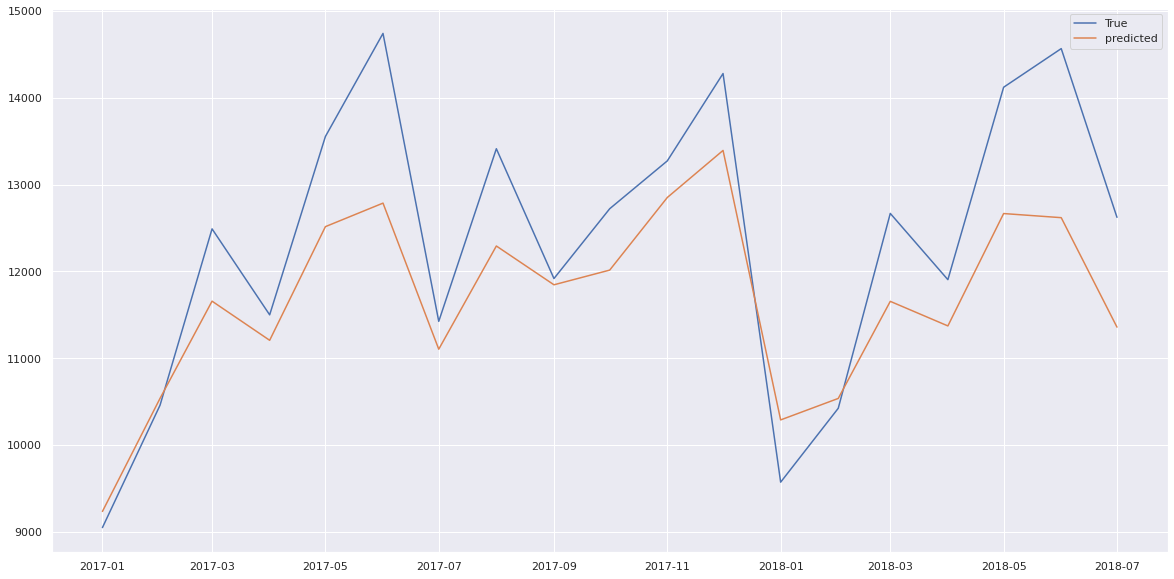

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style("darkgrid")

plt.figure(figsize=(20,10))
plt.plot(df_test[time_column_name], y_actual, label="True")
plt.plot(df_test[time_column_name], y_predict, label="predicted")
plt.legend()

## Clean up resources

Do not complete this section if you plan on running other Azure Machine Learning service tutorials.

### Stop the notebook VM

If you used a cloud notebook server, stop the VM when you are not using it to reduce cost.

1. In your workspace, select **Notebook VMs**.
1. From the list, select the VM.
1. Select **Stop**.
1. When you're ready to use the server again, select **Start**.

### Delete everything

If you don't plan to use the resources you created, delete them, so you don't incur any charges.

1. In the Azure portal, select **Resource groups** on the far left.
1. From the list, select the resource group you created.
1. Select **Delete resource group**.
1. Enter the resource group name. Then select **Delete**.

You can also keep the resource group but delete a single workspace. Display the workspace properties and select **Delete**.

## Next steps

In this automated machine learning tutorial, you did the following tasks:

> * Configured a workspace and prepared data for an experiment.
> * Trained by using an automated regression model locally with custom parameters.
> * Explored and reviewed training results.

[Deploy your model](https://docs.microsoft.com/azure/machine-learning/service/tutorial-deploy-models-with-aml) with Azure Machine Learning service.